*Read section 8.2.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time

In [50]:
#Using the same datsasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [51]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## Bagging regression trees

Bag regression trees to develop a model to predict car price using the predictors `mileage`,`mpg`,`year`,and `engineSize`. 

In [52]:
#Bagging the results of 10 decision trees to predict car price
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1,
                        n_jobs=-1).fit(X, y)

In [53]:
np.sqrt(mean_squared_error(test.price, model.predict(Xtest)))

5752.0779571060875

The RMSE has reduced a lot by averaging the predictions of 10 trees. The RMSE for a single tree model with optimized paramters was around 7000.

### Model accuracy vs number of trees

How does the model accuracy vary with the number of trees?

As we increase the number of trees, it will tend to reduce the variance of individual trees leading to a more accurate prediction.

In [14]:
#Finding model accuracy vs number of trees
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(10,400,40,dtype=int):
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=i, random_state=1,
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
    test_rsquared[i]=model.score(Xtest,ytest) #Returns the test R-squared of the model
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))
    test_rmse[i]=np.sqrt(mean_squared_error(model.predict(Xtest),ytest))

C:\Users\akl0407\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\akl0407\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


As we are bagging only 10 trees in the first iteration, some of the observations are selected in every bootstrapped sample, and thus they don't have an out-of-bag error, which is producing the warning. For every observation to have an out-of-bag error, the number of trees must be sufficiently large.

Let us visualize the out-of-bag (OOB) R-squared and R-squared on test data vs the number of trees.

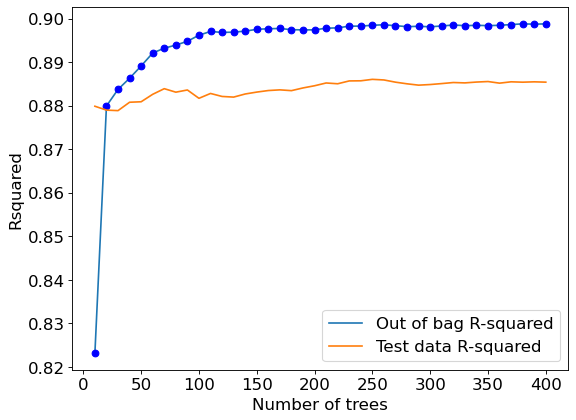

In [8]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

The out-of-bag R-squared initially increases, and then stabilizes after a certain number of trees (around 150 in this case). Note that increasing the number of trees further will not lead to overfitting. However, increasing the number of trees will increase the computations. Thus, we don't need to develop more trees once the R-squared stabilizes.

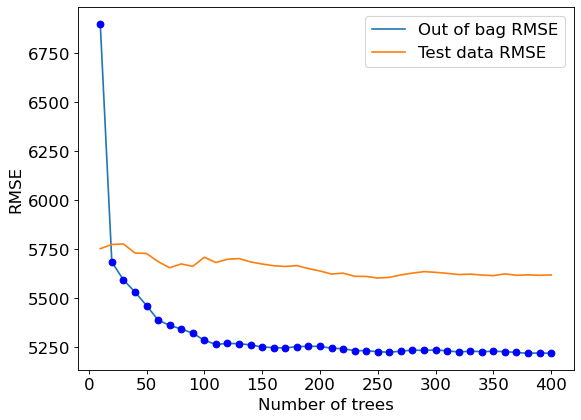

In [107]:
#Visualizing out-of-bag RMSE and test data RMSE
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

A similar trend can be seen by plotting out-of-bag RMSE and test RMSE. Note that RMSE is proportional to R-squared. We only need to visualize one of RMSE or R-squared to find the optimal number of trees.

In [15]:
#Bagging with 150 trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=150, random_state=1,
                        oob_score=True,n_jobs=-1).fit(X, y)

In [16]:
#OOB R-squared
model.oob_score_

0.897561533100511

In [17]:
#RMSE on test data
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(test.price, pred))

5673.756466489405

### Optimizing bagging hyperparameters using grid search
More parameters of a bagged regression tree model can be optimized using the typical approach of k-fold cross validation over a grid of parameter values.

In [54]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X, y))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(Xtest, ytest))
print('Best R^2 Score Through Grid Search : %.3f'%bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train R^2 Score : 0.986
Test R^2 Score : 0.885
Best R^2 Score Through Grid Search : 0.893
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


In [55]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=200, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=False,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

In [56]:
#RMSE on test data
np.sqrt(mean_squared_error(test.price, model.predict(Xtest)))

5638.330995970236

You may also use the object `bagging_regressor_grid` to directly make the prediction.

In [57]:
np.sqrt(mean_squared_error(test.price, bagging_regressor_grid.predict(Xtest)))

5638.330995970236

## Bagging for classification
Bag classification tree models to predict if a person has diabetes.

In [58]:
train = pd.read_csv('./Datasets/diabetes_train.csv')
test = pd.read_csv('./Datasets/diabetes_test.csv')

In [59]:
X = train.drop(columns = 'Outcome')
Xtest = test.drop(columns = 'Outcome')
y = train['Outcome']
ytest = test['Outcome']

In [22]:
#Bagging the results of 10 decision trees to predict car price
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150, random_state=1,
                        n_jobs=-1).fit(X, y)

Accuracy:  76.62337662337663
ROC-AUC:  0.8766084963863917
Precision:  0.6404494382022472
Recall:  0.9344262295081968


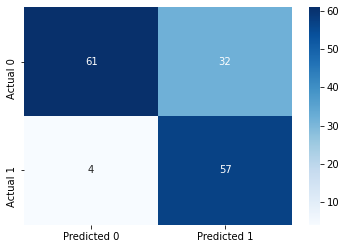

In [38]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.23

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

As a result of bagging, we obtain a model (with a threshold probabiltiy cutoff of 0.23) that has a better performance on test data in terms of almost all the metrics - accuracy, precision (comparable performance), recall, and ROC-AUC, as compared the single tree classification model (with a threshold probability cutoff of 0.23). Note that we have not yet tuned the model using `GridSearchCv` here, which is shown towards the end of this chapter.

### Model accuracy vs number of trees

In [60]:
#Finding model accuracy vs number of trees
oob_accuracy={};test_accuracy={};oob_rmse={};test_rmse = {}
for i in np.linspace(10,400,40,dtype=int):
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=i, random_state=1,
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_accuracy[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
    test_accuracy[i]=model.score(Xtest,ytest) #Returns the test R-squared of the model

C:\Users\akl0407\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\akl0407\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


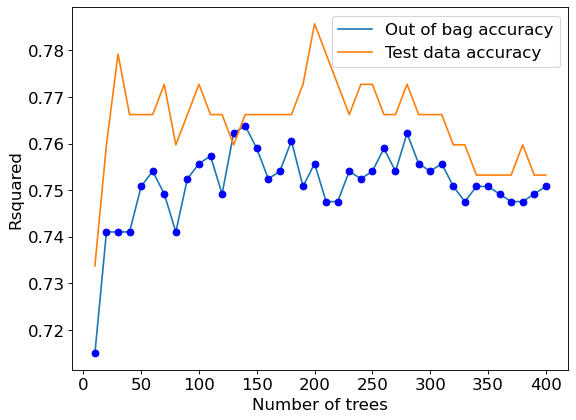

In [62]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_accuracy.keys(),oob_accuracy.values(),label = 'Out of bag accuracy')
plt.plot(oob_accuracy.keys(),oob_accuracy.values(),'o',color = 'blue')
plt.plot(test_accuracy.keys(),test_accuracy.values(), label = 'Test data accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

1.0


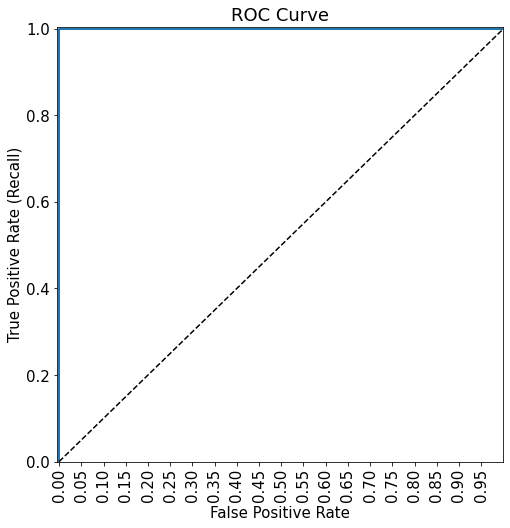

In [63]:
#ROC curve on training data
ypred = model.predict_proba(X)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

Note that there is perfect separation in train data as ROC-AUC = 1. This shows that the model is probably overfitting. However, this also shows that, despite the reduced variance *(as compared to a single tree)*, the bagged tree model is flexibly enough to perfectly separate the classes.

ROC-AUC =  0.8781949585757096


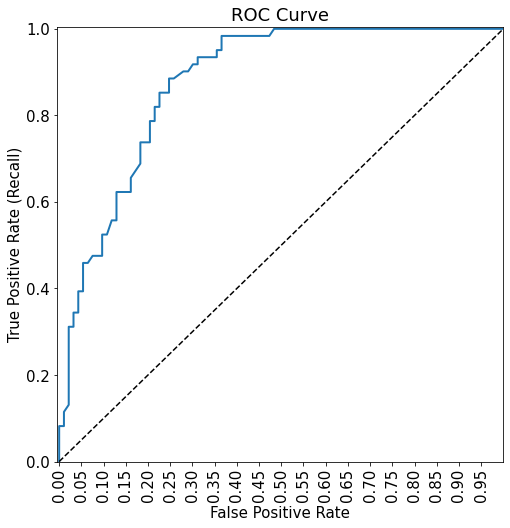

In [65]:
#ROC curve on test data
ypred = model.predict_proba(Xtest)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(ytest, ypred)
print("ROC-AUC = ",auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(ytest, ypred)
plot_roc_curve(fpr, tpr)

### Optimizing bagging hyperparameters using grid search
More parameters of a bagged classification tree model can be optimized using the typical approach of k-fold cross validation over a grid of parameter values.

In [67]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator': [DecisionTreeClassifier(random_state = 1),LogisticRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X, y)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X, y))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(Xtest, ytest))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train accuracy : 1.000
Test accuracy : 0.786
Best accuracy Through Grid Search : 0.573
Best Parameters :  {'base_estimator': DecisionTreeClassifier(random_state=1), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


### Tuning the decision threshold probability

We'll find a decision threshold probability that balances recall with precision.

In [113]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=200, 
                          random_state=1,max_features=1.0, oob_score=True,
                        max_samples=1.0,n_jobs=-1,bootstrap=True,bootstrap_features=False).fit(X, y)

As the model is overfitting on the train data, it will not be a good idea to tune the decision threshold probability based on the precision-recall curve on train data, as shown in the figure below.

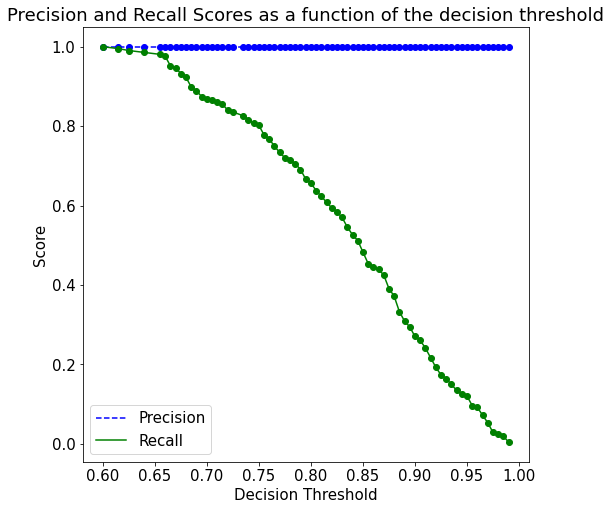

In [114]:
ypred = model.predict_proba(X)[:,1]
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Instead, we should make the precision-recall curve using the out-of-bag predictions, as shown below. The method `oob_decision_function_` provides the predicted probability.

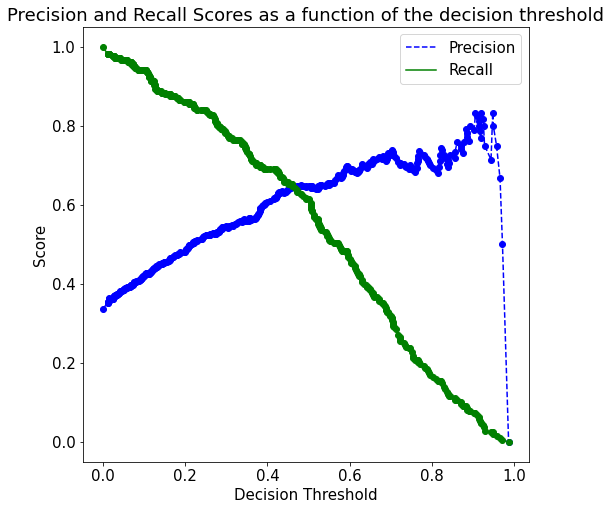

In [115]:
ypred = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [116]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probabiltiy for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.2804878 , 0.53205128, 0.80193237])

Suppose, we wish to have at least 80% recall, with the highest possible precision. Then, based on the precision-recall curve, we should have a decision threshold probability of 0.28.

Accuracy:  79.22077922077922
ROC-AUC:  0.8802221047065044
Precision:  0.6705882352941176
Recall:  0.9344262295081968


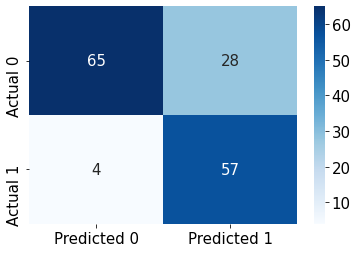

In [98]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.28

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Note that this model has a better performance than the untuned bagged model earlier, and the single tree classification model, as expected.